In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import string

from cgeniepy.ecology import EcoModel
from cgeniepy.array import GriddedData

plt.rcParams['font.family'] = 'Helvetica'

GriddedData.modify_in_place = False

In [24]:
# Modern observational data (ForCenS database)
forcens = pd.read_csv("~/Science/lgm_foram_census/tidy/forcens_fg_r_tidy.csv")

# Compute symbiotic vs non-symbiotic relative abundance
# Symbiotic: symbiont-obligate spinose (ss) + symbiont-facultative non-spinose (sn)
# Non-symbiotic: symbiont-barren non-spinose (bn) + symbiont-barren spinose (bs)
bn = forcens['symbiont-barren non-spinose'].values
bs = forcens['symbiont-barren spinose'].values
sn = forcens['symbiont-facultative non-spinose'].values
ss = forcens['symbiont-obligate spinose'].values
total_obs = bn + bs + sn + ss

forcens_sym = forcens[['Latitude', 'Longitude']].copy()
forcens_sym['Symbiotic'] = (ss + sn) / total_obs

forcens_nonsym = forcens[['Latitude', 'Longitude']].copy()
forcens_nonsym['Non-symbiotic'] = (bn + bs) / total_obs

In [25]:
# Modern model (pre-industrial, ForamEcoGENIE)
mod_pi = EcoModel(
    "/Users/yingrui/science/lgm_foram_niche/model/muffin.CBE.worlg4.BASESFeTDTL.SPIN",
    gemflag='ecogem'
)

# PFT numbers: bn=16, bs=17, sn=18, ss=19
biomass_bn = mod_pi.get_pft(16).isel(time=-1).data
biomass_bs = mod_pi.get_pft(17).isel(time=-1).data
biomass_sn = mod_pi.get_pft(18).isel(time=-1).data
biomass_ss = mod_pi.get_pft(19).isel(time=-1).data

# Get volumes from model parameters and convert biomass to abundance
# Abundance = Biomass / q_C, where q_C ∝ volume (constant factors cancel in relative abundance)
pars = mod_pi.eco_pars()
vol_bn = pars.query("PFT == 'foram_bn'")['volume'].values[0]
vol_bs = pars.query("PFT == 'foram_bs'")['volume'].values[0]
vol_sn = pars.query("PFT == 'foram_sn'")['volume'].values[0]
vol_ss = pars.query("PFT == 'foram_ss'")['volume'].values[0]

abun_bn = biomass_bn / vol_bn
abun_bs = biomass_bs / vol_bs
abun_sn = biomass_sn / vol_sn
abun_ss = biomass_ss / vol_ss

total_abun = abun_bn + abun_bs + abun_sn + abun_ss
sym_rel_modern = GriddedData((abun_ss + abun_sn) / total_abun)
nonsym_rel_modern = GriddedData((abun_bn + abun_bs) / total_abun)

In [26]:
import pandas as pd

# Cretaceous model (Maastrichtian, EcoGENIE)
# Use the main experiment; time=0 is the pre-impact steady state
model_cret = EcoModel(
    "../model/muffin.u067bc.PO4Fe.main/",
    gemflag=['biogem', 'ecogem']
)

arctic_mask = xr.load_dataarray("../data/masked_array.nc")
model_mask = model_cret.grid_mask()

# Non-symbiotic foram: PFTs 97-104
# Symbiotic foram: PFTs 105-112
nonsym_foram_index = np.arange(96, 104)
sym_foram_index = np.arange(104, 112)

# Get volumes from trait data and allometric parameters
trait_df = pd.read_csv('../output/trait_df.csv')
nonsym_volume = trait_df.iloc[97:105]['volume'].values
sym_volume = trait_df.iloc[105:113]['volume'].values

qcarbon_a = model_cret.get_config('ECOGEM')['qcarbon_a']
qcarbon_b = model_cret.get_config('ECOGEM')['qcarbon_b']

nonsym_q_C = qcarbon_a * (nonsym_volume ** qcarbon_b)
sym_q_C = qcarbon_a * (sym_volume ** qcarbon_b)

# Get individual PFT biomasses at pre-impact (time=0)
nonsym_foram_individual = model_cret.get_pft(list(nonsym_foram_index + 1)).data.isel(time=0) * model_mask * arctic_mask
sym_foram_individual = model_cret.get_pft(list(sym_foram_index + 1)).data.isel(time=0) * model_mask * arctic_mask

# Convert biomass to abundance for each PFT
nonsym_abundance = nonsym_foram_individual.copy()
sym_abundance = sym_foram_individual.copy()

for i, q_C in enumerate(nonsym_q_C):
    nonsym_abundance[i] = nonsym_foram_individual[i] / q_C

for i, q_C in enumerate(sym_q_C):
    sym_abundance[i] = sym_foram_individual[i] / q_C

# Sum across PFTs and compute relative abundance
nonsym_total_abun = nonsym_abundance.sum(dim='variable')
sym_total_abun = sym_abundance.sum(dim='variable')
total_abun_cret = nonsym_total_abun + sym_total_abun

sym_rel_cret = GriddedData(sym_total_abun / total_abun_cret)
nonsym_rel_cret = GriddedData(nonsym_total_abun / total_abun_cret)

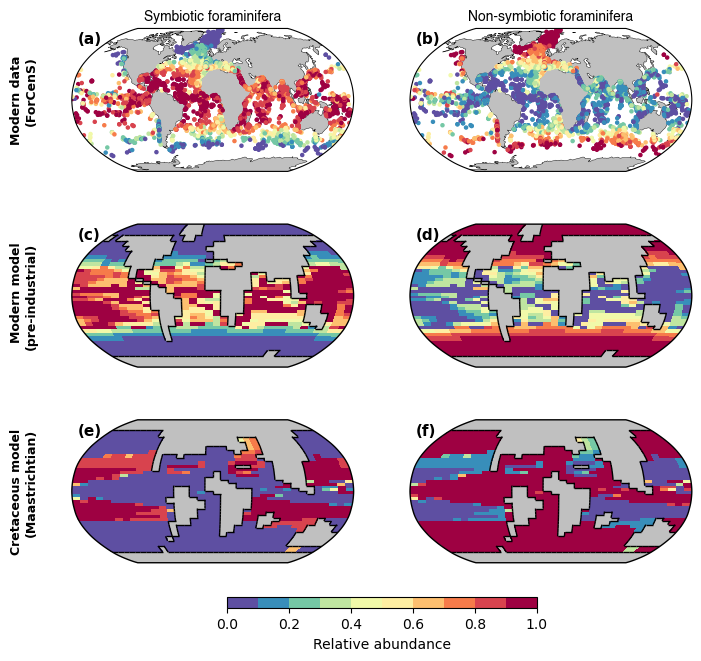

In [27]:
fig, axes = plt.subplots(
    3, 2, figsize=(8, 9),
    subplot_kw={'projection': ccrs.Robinson()}
)

cmap = plt.get_cmap("Spectral_r", 10)

# --- Row 1: Modern Data (ForCenS) ---
for ax in axes[0]:
    ax.add_feature(cfeature.LAND, facecolor='silver', edgecolor='k', linewidth=0.3)
    ax.set_global()

axes[0, 0].scatter(
    forcens_sym['Longitude'], forcens_sym['Latitude'],
    c=forcens_sym['Symbiotic'], cmap=cmap, vmin=0, vmax=1,
    s=5, transform=ccrs.PlateCarree()
)
axes[0, 1].scatter(
    forcens_nonsym['Longitude'], forcens_nonsym['Latitude'],
    c=forcens_nonsym['Non-symbiotic'], cmap=cmap, vmin=0, vmax=1,
    s=5, transform=ccrs.PlateCarree()
)

# --- Row 2: Modern Model ---
sym_rel_modern.plot(
    ax=axes[1, 0], vmin=0, vmax=1, cmap=cmap, colorbar=False, outline=True
)
nonsym_rel_modern.plot(
    ax=axes[1, 1], vmin=0, vmax=1, cmap=cmap, colorbar=False, outline=True
)

# --- Row 3: Cretaceous Model ---
sym_rel_cret.plot(
    ax=axes[2, 0], vmin=0, vmax=1, cmap=cmap, colorbar=False, outline=True
)
p = nonsym_rel_cret.plot(
    ax=axes[2, 1], vmin=0, vmax=1, cmap=cmap, colorbar=False, outline=True
)

# Column titles
axes[0, 0].set_title('Symbiotic foraminifera', fontsize=10, fontweight='bold')
axes[0, 1].set_title('Non-symbiotic foraminifera', fontsize=10, fontweight='bold')

# Row labels
row_labels = [
    'Modern data\n(ForCenS)',
    'Modern model\n(pre-industrial)',
    'Cretaceous model\n(Maastrichtian)'
]
for i, label in enumerate(row_labels):
    axes[i, 0].text(
        -0.12, 0.5, label, transform=axes[i, 0].transAxes,
        fontsize=9, fontweight='bold', va='center', ha='right', rotation=90
    )

# Panel labels (a-f)
for i, ax in enumerate(axes.flat):
    ax.text(
        0.02, 0.98, f'({string.ascii_lowercase[i]})',
        transform=ax.transAxes, fontsize=11, fontweight='bold', va='top'
    )

# Shared colorbar
cbar = fig.colorbar(
    p, ax=axes.flatten().tolist(),
    orientation='horizontal', pad=0.05, aspect=30, shrink=0.5
)
cbar.set_label('Relative abundance', fontsize=10)

fig.savefig('../output/foram_sym_nonsym_comparison.png', dpi=300, bbox_inches='tight')
plt.show()